# **Local regression**

**Presented by:**

_Giacomo Melloni, Tore Gude, Torstein Nordgård-Hansen_

**Date:**

_September 11th 2024_


## 1) Some theory

LOESS (Locally Estimated Scatterplot Smoothing) or LOWESS (Locally Weighted Scatterplot Smoothing) is a non-parametric method for performing local regression. In the context of multivariate analysis, LOESS is an approach used to fit a smooth curve or surface to data by applying regression locally to small subsets of the data.

Instead of fitting a global model to the entire dataset (as in traditional regression), LOESS fits a local model to the data points. LOESS assigns weights to the data points in the local neighborhood, giving more importance to data points that are closer to the target point. Points further away are given lower weights. The most commonly used weighting function is the tri-cube weighting function:

$$
W(x, t) =
\begin{cases}
\left(1 - \left|\frac{x^3}{r^3}\right|^3\right)^3 & 0 \leq |x| \leq r, \\
0 & |x| > t.
\end{cases}
$$

where the radius _r_ is the distance beyond which the kernel gives a weight of 0. The size of the local neighborhood is controlled by the smoothing parameter or bandwidth (NOTE: radius is essentially a function of the bandwidth. The bandwidth defines how far the "local" window extends from the target point, and the radius corresponds to the physical distance from the target point within which the data points are considered).

Within each local neighborhood, LOESS typically fits a low-degree polynomial (1 or 2) to the data. This polynomial regression is fitted to the weighted data points in the local neighborhood.

Two types of local regression algorithms are defined based on the decision of the bandwidth:

### A. Constant bandwidth: 

the bandwidth is $h(x) = h$. Problem: when nonuniform distribution of the datasets, this leasd to problems with empty neighborhood (see example below).s

### B. Nearest neighbor bandwidth

It chooses thebandwidthw $h(x)$ such that the local neighborhood always contains a specified number of points. For a smoothing parameter $\alpha$ between 0 and 1, the nearest neighbor bandwidth $h(x)$ is computed as follows:

1. Compute the distances $ d(x, x_i) = |x - x_i| $ between the fitting point $x$ and the data points $x_i$ ;

2. Choose $h(x)$ to be the $k$-th smallest distance, where $k = \lfloor n \alpha \rfloor $.

In this example, we study the performance of constant and dynamic bandwidth for LOESS. The purpose is to fit a know nonlinear surface under uniform and nonuniform distributed dataset. The library we use is called [LOCALREG](https://github.com/sigvaldm/localreg) (it implements LOESS and LOWESS).

In [3]:
%pip install localreg

  Using cached localreg-0.5.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
from localreg import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

N = 500

## 2) Uniform distributed dataset

The dataset $X$ is uniform distributed between 0 and 1 in both $x_1$ and $x_2$ axis.

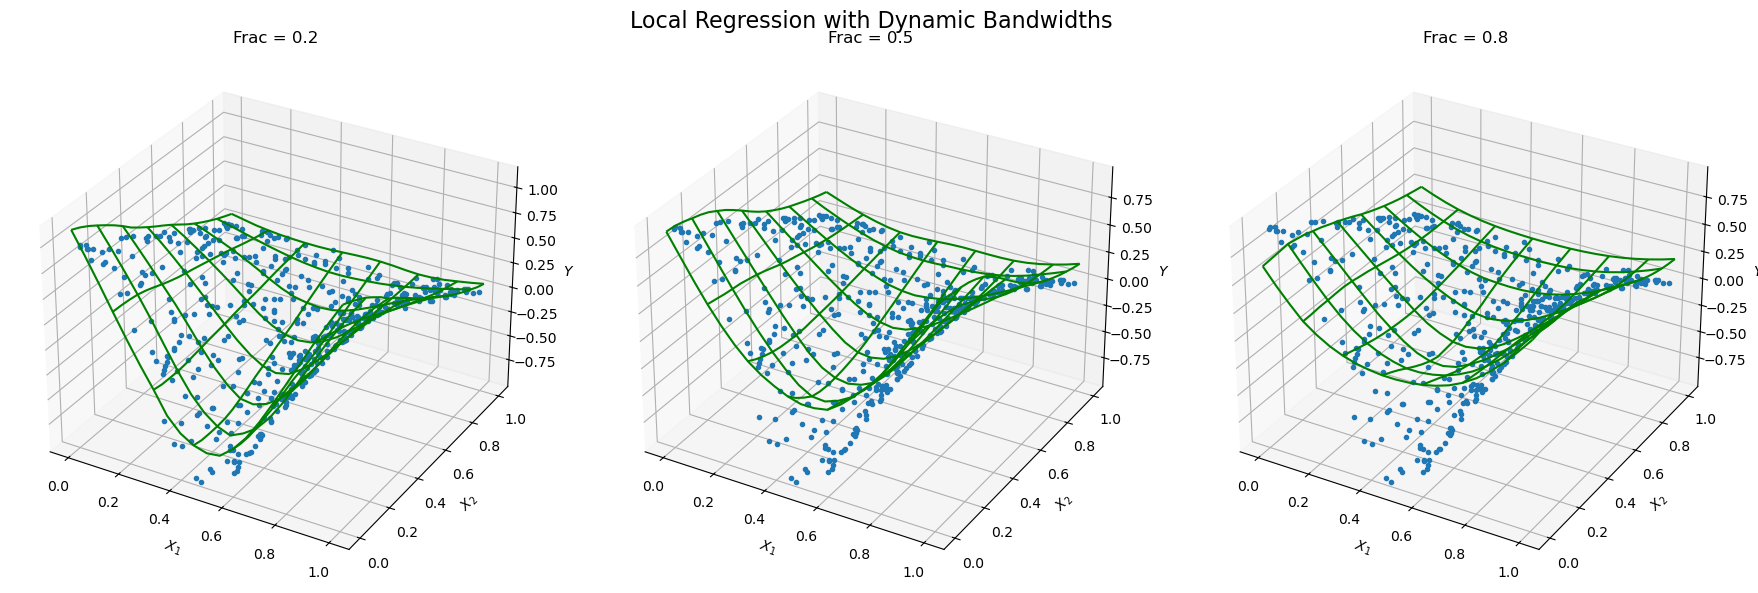

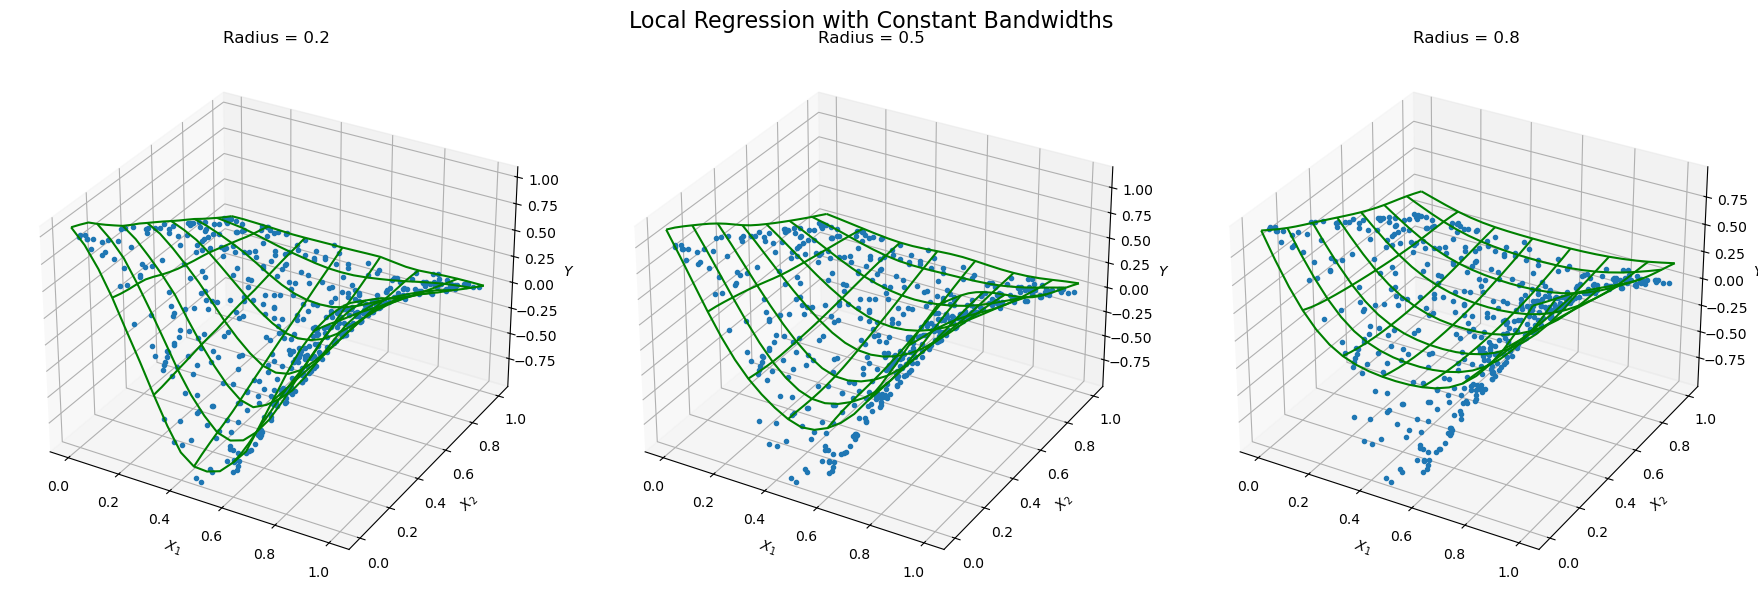

In [2]:
# Degree of the polynomial
degree=1

# Create a uniform distribution for X with interval [0, 1]
x = np.random.rand(N,2)

# Define the dataset Y
y = np.cos(2*np.pi*x[:,0]) * (1 - x[:,1])

m = np.arange(0, 1.05, 0.05)
X1, X2 = np.meshgrid(m,m)

#  x0 is the x-values at which to compute smoothed values
x0 = np.array([np.ravel(X1), np.ravel(X2)]).T

# Define parameters for fractions and radii
frac_values = [0.2, 0.5, 0.8] # fraction of dataset used for smoothing (i.e. the number of points used in the dynamic bw algorithm)
radius_values = [0.2, 0.5, 0.8] # radius of the weighting function (see the theory section)

# Function to compute and reshape local regression results
def compute_localreg(x, y, x0, degree, kernel, param, param_type='frac'):
    if param_type == 'frac':
        return localreg(x, y, x0, degree=degree, kernel=kernel, frac=param).reshape(X1.shape)
    else:
        return localreg(x, y, x0, degree=degree, kernel=kernel, radius=param).reshape(X1.shape)

# Generate and plot the local regression with different bandwidths (frac)
def plot_localreg(X, Y, Z_list, x, y, titles, suptitle):
    fig = plt.figure(figsize=(18, 6))
    for i, (Z, title) in enumerate(zip(Z_list, titles), 1):
        ax = fig.add_subplot(1, 3, i, projection='3d')
        ax.plot_wireframe(X, Y, Z, rcount=10, ccount=10, color='green')
        ax.plot3D(x[:, 0], x[:, 1], y, '.')
        ax.set_title(title)
        ax.set_xlabel('$X_1$')
        ax.set_ylabel('$X_2$')
        ax.set_zlabel('$Y$')
    fig.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    plt.show()

# Compute local regression for dynamic bandwidths (frac)
Y_frac = [compute_localreg(x, y, x0, degree, rbf.tricube, f, param_type='frac') for f in frac_values]
plot_localreg(X1, X2, Y_frac, x, y, [f'Frac = {f}' for f in frac_values], 'Local Regression with Dynamic Bandwidths')

# Compute local regression for constant bandwidths (radius)
Y_radius = [compute_localreg(x, y, x0, degree, rbf.tricube, r, param_type='radius') for r in radius_values]
plot_localreg(X1, X2, Y_radius, x, y, [f'Radius = {r}' for r in radius_values], 'Local Regression with Constant Bandwidths')

### Comments:
1. Constant bandwidth works better in uniform distributed dataset X
   
3. By increasing the degree of the polynomial, constant and dynamic bw converge. Of course, using high order polynomials means having large 
numbers of coefficients to estimate, and the result is higher variability in the estimate.

## 3) Nonuniform dataset

The dataset $X$ is nonuniform distributed. Two clusters (x1 and x2) are defined. Both are Gaussian distributed, with different mean an variance.

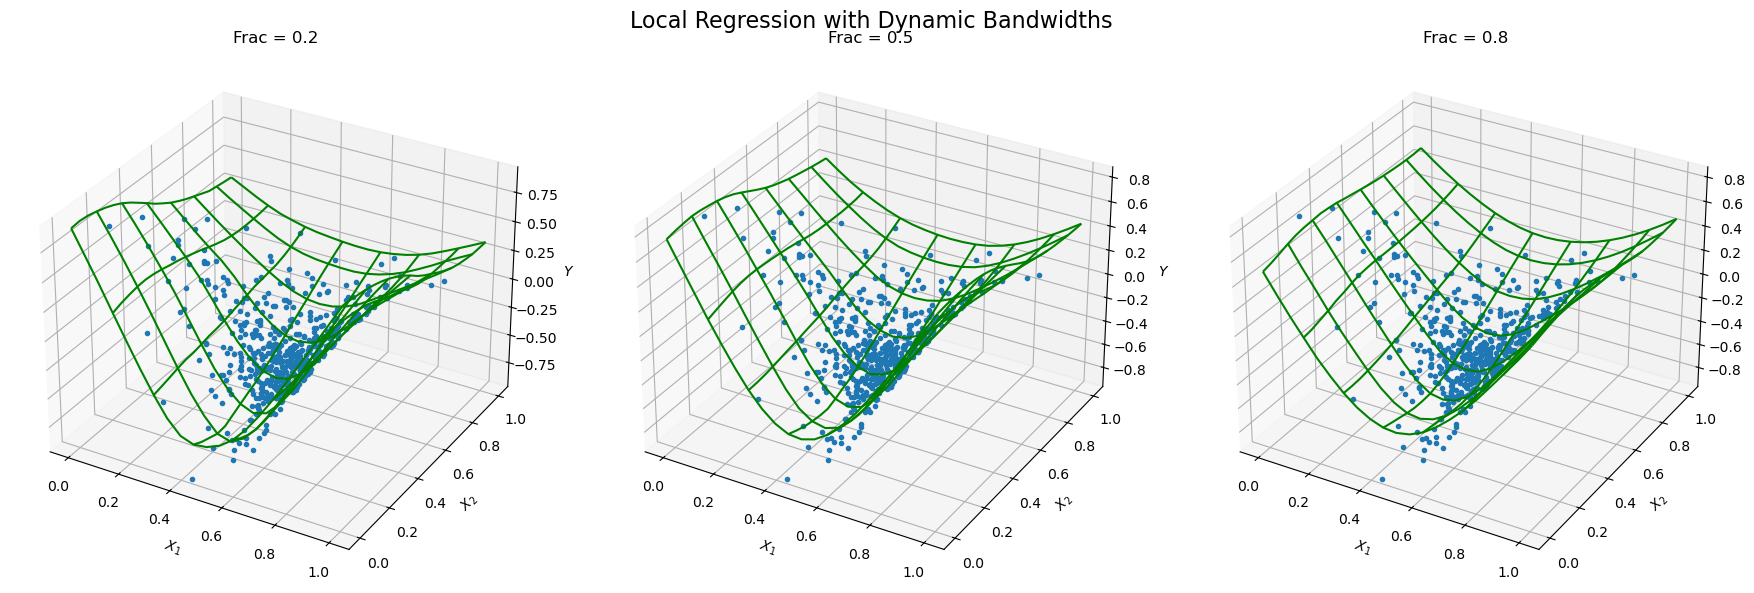

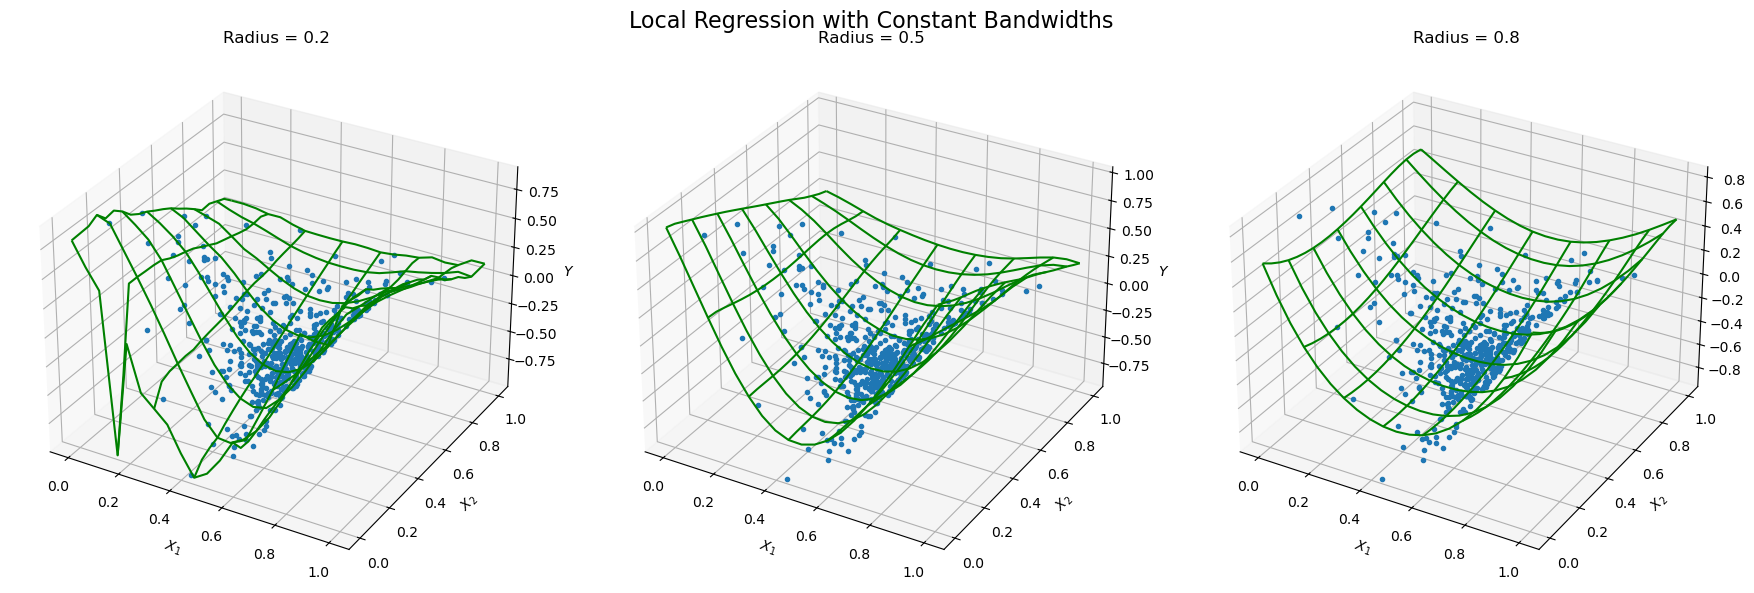

In [11]:
# Degree of the polynomial
degree=1

# Create a non-uniform distribution for x by mixing two normal distributions with interval [0, 1]
x1 = np.random.normal(loc=0.5, scale=0.1, size=(int(N*0.6), 2))  # Dense cluster
x1 = np.clip(x1, 0, 1)
x2 = np.random.normal(loc=0.5, scale=0.2, size=(int(N*0.4), 2))  # Sparse cluster
x2 = np.clip(x2, 0, 1)

# Combine both clusters to create non-uniform data
x = np.vstack((x1, x2))

# Define the dataset
y = np.cos(2*np.pi*x[:,0]) * (1 - x[:,1])

m = np.arange(0, 1.05, 0.05)
X1, X2 = np.meshgrid(m,m)
x0 = np.array([np.ravel(X1), np.ravel(X2)]).T

# Define parameters for fractions and radii
frac_values = [0.2, 0.5, 0.8]
radius_values = [0.2, 0.5, 0.8]

# Function to compute and reshape local regression results
def compute_localreg(x, y, x0, degree, kernel, param, param_type='frac'):
    if param_type == 'frac':
        return localreg(x, y, x0, degree=degree, kernel=kernel, frac=param).reshape(X1.shape)
    else:
        return localreg(x, y, x0, degree=degree, kernel=kernel, radius=param).reshape(X1.shape)

# Generate and plot the local regression with different bandwidths (frac)
def plot_localreg(X, Y, Z_list, x, y, titles, suptitle):
    fig = plt.figure(figsize=(18, 6))
    for i, (Z, title) in enumerate(zip(Z_list, titles), 1):
        ax = fig.add_subplot(1, 3, i, projection='3d')
        ax.plot_wireframe(X, Y, Z, rcount=10, ccount=10, color='green')
        ax.plot3D(x[:, 0], x[:, 1], y, '.')
        ax.set_title(title)
        ax.set_xlabel('$X_1$')
        ax.set_ylabel('$X_2$')
        ax.set_zlabel('$Y$')
    fig.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    plt.show()

# Compute local regression for dynamic bandwidths (frac)
Y_frac = [compute_localreg(x, y, x0, degree, rbf.tricube, f, param_type='frac') for f in frac_values]
plot_localreg(X1, X2, Y_frac, x, y, [f'Frac = {f}' for f in frac_values], 'Local Regression with Dynamic Bandwidths')

# Compute local regression for constant bandwidths (radius)
Y_radius = [compute_localreg(x, y, x0, degree, rbf.tricube, r, param_type='radius') for r in radius_values]
plot_localreg(X1, X2, Y_radius, x, y, [f'Radius = {r}' for r in radius_values], 'Local Regression with Constant Bandwidths')

### Comments:
1. For small fraction of dataset values (frac), dynamic bandwidth works better in nonniform distributed dataset X. This is because in constant bw, there are neighbors (i.e. windows where the smoothing procedure is performed) with empty points;

2. Instead, constant bw works better for big values of radius. In this case, the number of empy neighbors are reduce because of incresed bandwidth;

3. No improvement by increasing the degree of the polynomial. This is because of "holes" in the dataset, so the polyfit function does not work.

## 4) Diagnostic tool

In local regression studies, one is faced with several model selection issues: variable selection, choice of local polynomial degree and smoothing parameters. An ideal aim may be fully automated methods: We plug data into a program, and it automatically returns the best fit. But this goal is unattainable, since the best fit depends not only on the data, but on the questions of interest. Residual plots, degrees of freedom and confidence intervals. It is important to remember that no one diagnostic technique will explain the whole story of a dataset.

### A. Residuals

The residuals are the differences between the observed data points and the fitted values from the loess curve. They can be used to assess the quality of the fit and to identify potential outliers or patterns in the data. 
The residual function is:

$$
\hat{\epsilon}_i = Y_i - \hat{\mu}(x_i).
$$

where $\hat{\mu}(x_i)$ is the estimate obtained by performing local regression.

__NOTE__: _run either linear or nonlinear codes to define the the distribution of the dataset._

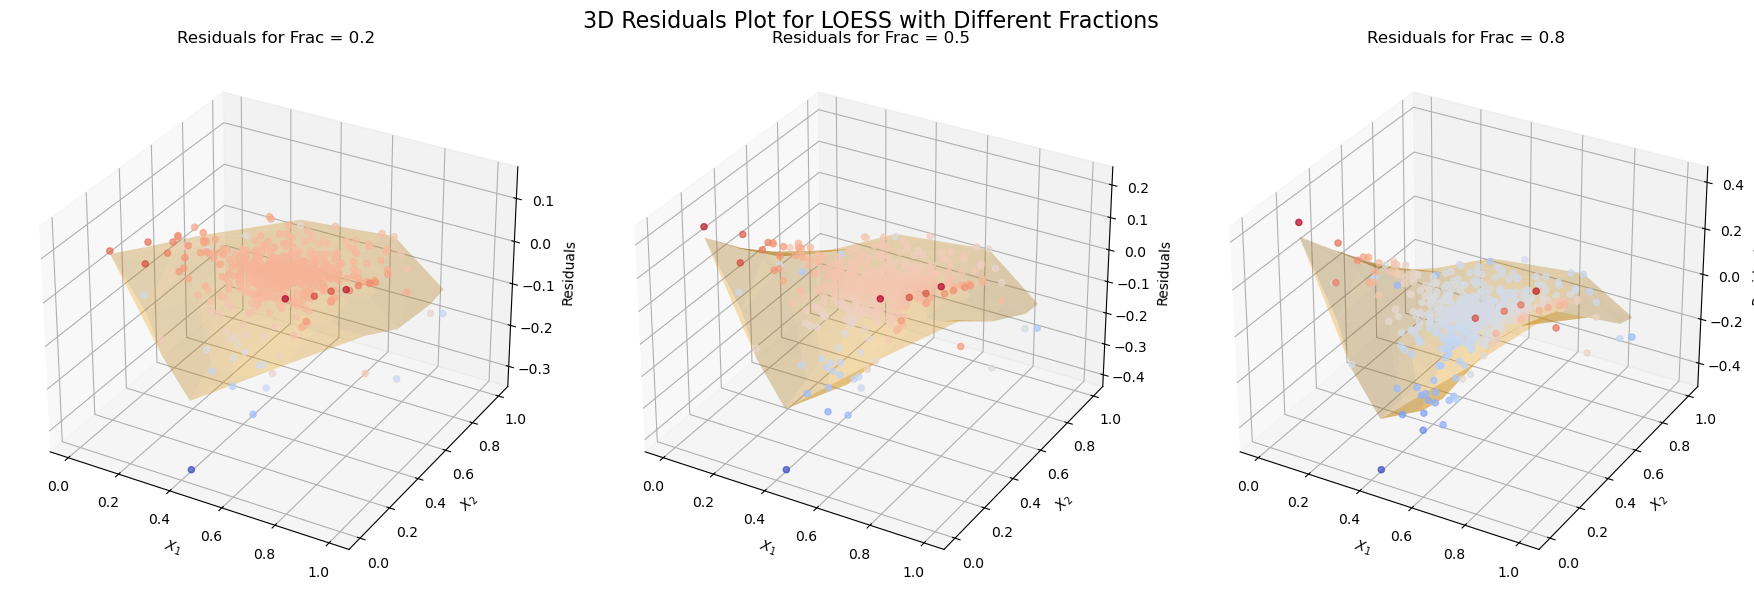

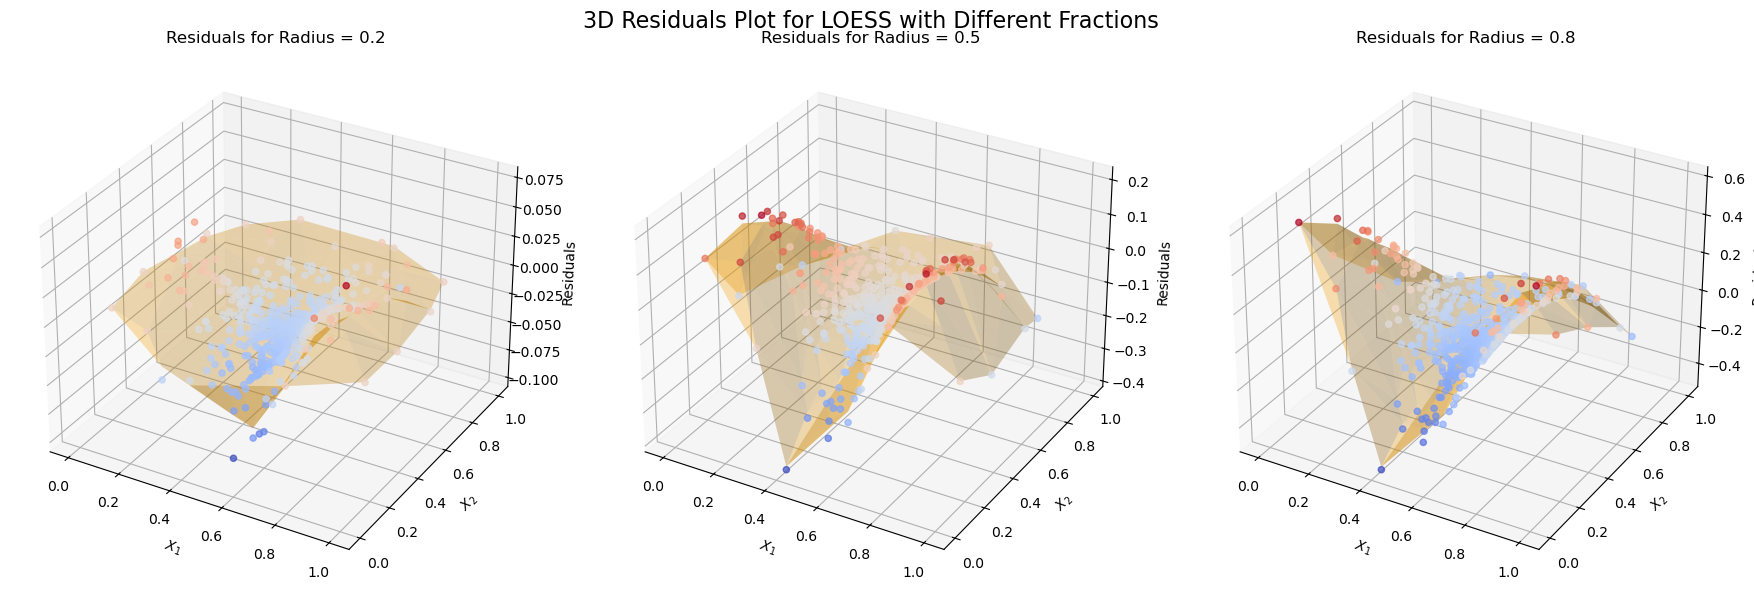

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Function to compute and reshape local regression results
def compute_localreg(x, y, x0, degree, kernel, param, param_type='frac'):
    if param_type == 'frac':
        return localreg(x, y, x0, degree=degree, kernel=kernel, radius=param).reshape(X1.shape)
    else:
        return localreg(x, y, x0, degree=degree, kernel=kernel, radius=param).reshape(X1.shape)

# Compute residuals for each model and plot in 3D
def plot_3d_residuals_DYNAMIC(x, y, x0, frac_values, degree):
    fig = plt.figure(figsize=(18, 6))
    
    for i, frac in enumerate(frac_values):
        # Fit the model to the data with LOESS/LOWESS
        y_pred = localreg(x, y, x, degree=degree, kernel=rbf.tricube, frac=frac)
        
        # Compute residuals
        residuals = y - y_pred

        # Fit LOESS on residuals
        residuals_pred = localreg(x, residuals, x, degree=degree, kernel=rbf.tricube, frac=0.2)
        
        # 3D scatter plot of residuals
        ax = fig.add_subplot(1, len(frac_values), i+1, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], residuals, c=residuals, cmap='coolwarm', alpha=0.7)
        ax.set_title(f'Residuals for Frac = {frac}')
        ax.set_xlabel('$X_1$')
        ax.set_ylabel('$X_2$')
        ax.set_zlabel('Residuals')

        # Overlay the LOESS fit for residuals as a surface
        ax.plot_trisurf(x[:, 0], x[:, 1], residuals_pred, color='orange', alpha=0.3, label="LOESS Fit")
    
    fig.suptitle('3D Residuals Plot for LOESS with Different Fractions', fontsize=16)
    plt.tight_layout()
    plt.show()

# Compute residuals for each model and plot in 3D
def plot_3d_residuals_CONSTANT(x, y, x0, radius_values, degree):
    fig = plt.figure(figsize=(18, 6))
    
    for i, radius in enumerate(radius_values):
        # Fit the model to the data with LOESS/LOWESS
        y_pred = localreg(x, y, x, degree=degree, kernel=rbf.tricube, radius=radius)
        
        # Compute residuals
        residuals = y - y_pred

        # Fit LOESS on residuals
        residuals_pred = localreg(x, residuals, x, degree=degree, kernel=rbf.tricube, radius=0.2)
        
        # 3D scatter plot of residuals
        ax = fig.add_subplot(1, len(frac_values), i+1, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], residuals, c=residuals, cmap='coolwarm', alpha=0.7)
        ax.set_title(f'Residuals for Radius = {radius}')
        ax.set_xlabel('$X_1$')
        ax.set_ylabel('$X_2$')
        ax.set_zlabel('Residuals')

        # Overlay the LOESS fit for residuals as a surface
        ax.plot_trisurf(x[:, 0], x[:, 1], residuals_pred, color='orange', alpha=0.3, label="LOESS Fit")
    
    fig.suptitle('3D Residuals Plot for LOESS with Different Fractions', fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the residual plotting function for LOESS with dynamic bandwidths in 3D
plot_3d_residuals_DYNAMIC(x, y, x0, frac_values, degree)

# Call the residual plotting function for LOESS with constant bandwidths in 3D
plot_3d_residuals_CONSTANT(x, y, x0, radius_values, degree)

### Comments:
1. Case with uniform distributed data: for Frac = 0.2, the residuals are limited in a smaller intervall (almost between 0.1 and -0.25) and for Frac = 0.8, the interval is wider. This means that the loess with Frac = 0.2 fits better the dataset. However, this does not mean that the Frac = 0.2 is noise free.

2. Case with nonuniform dataset: constant bw seems to work better than dynamic bw for small radius (small interval of variability) but by looking the estimated curve using Radius = 0.2, it is clear that the estimation craps.

3. In both cases, the residuals show that for high Frac and Radius values, part of the dataset is not properly modeled (see orange surfaces).

### B. Influence and Variance plots
__Influence Plot__: visualizes how much each nearby point contributes to the model’s prediction at a target point. It shows how the parameter estimates would change if the considered points were excluded. Sometimes a small group of influential points can have a large impact on the fit of the model

__Variance Plot__: shows the uncertainty or variability in the model’s predictions at each point. It reflects how stable the local regression fit is in different regions.

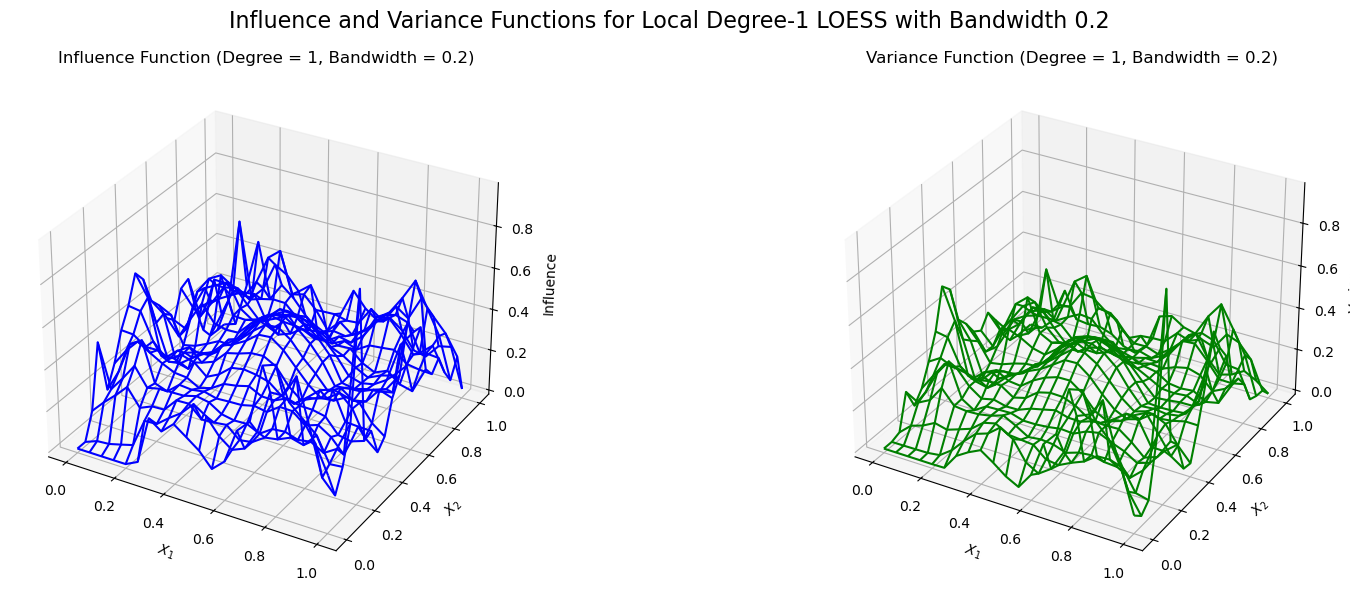

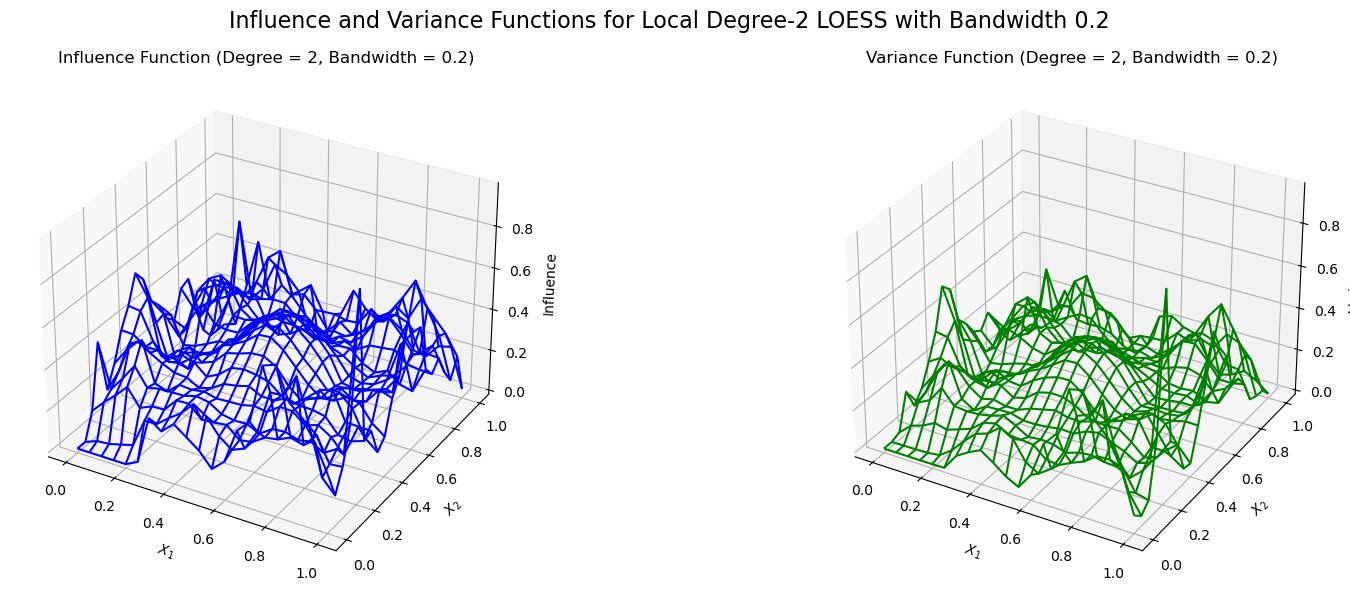

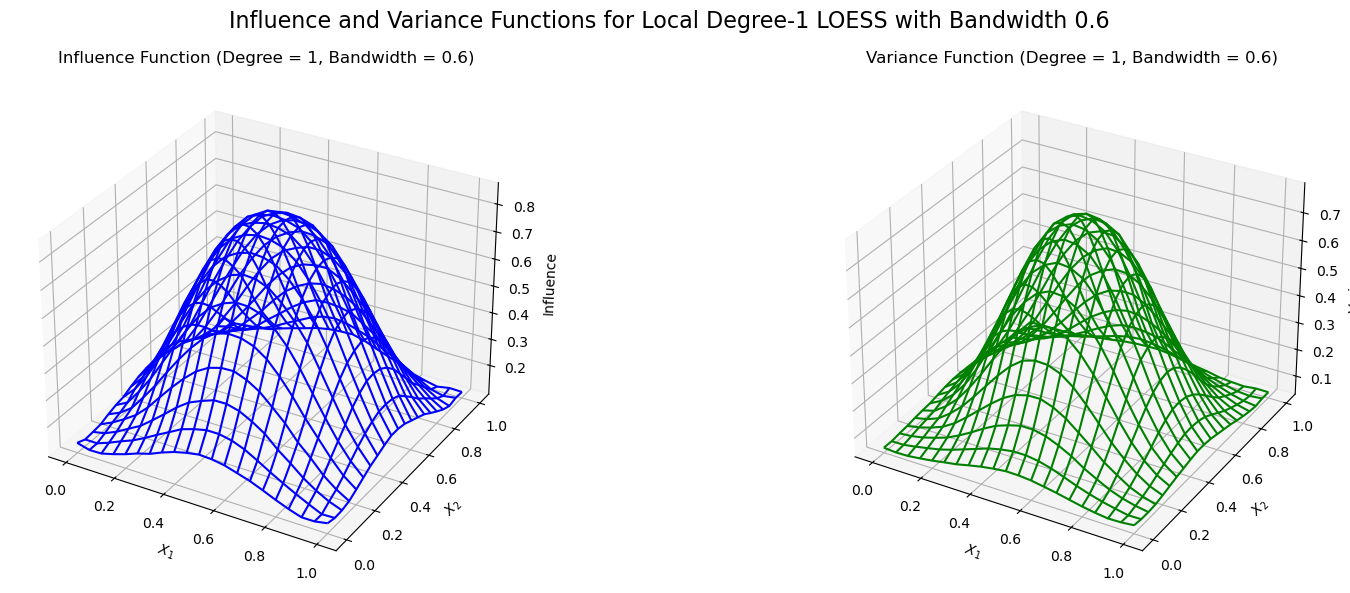

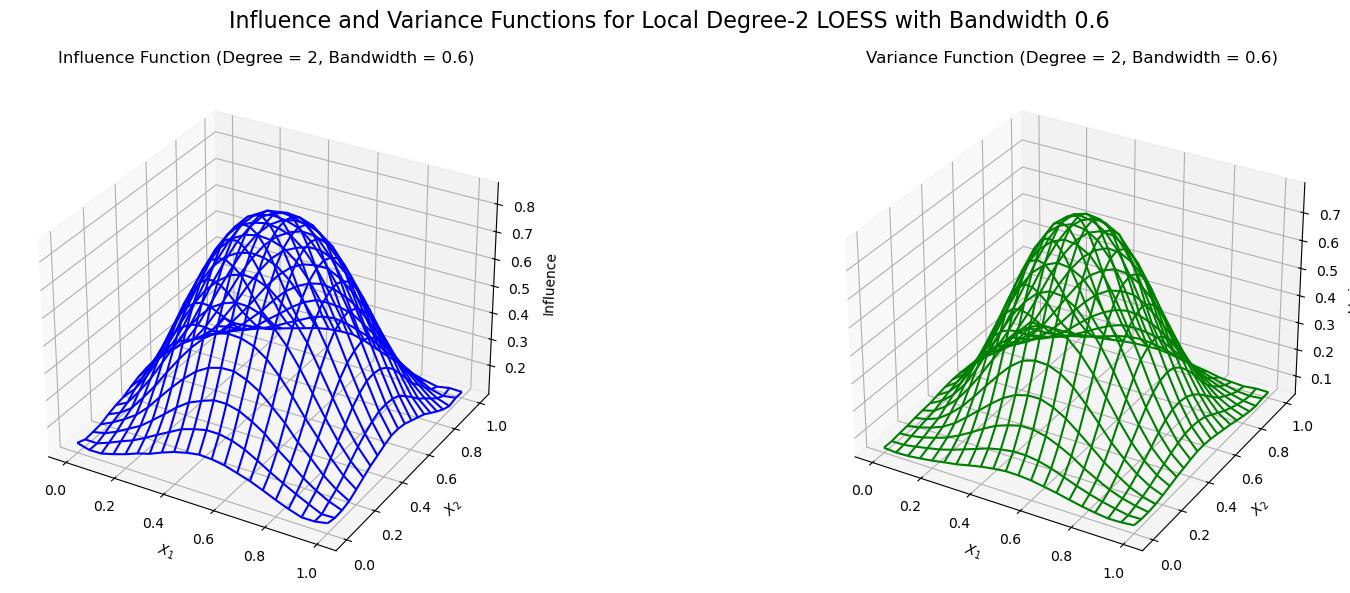

In [10]:
# Define the kernel function for influence and variance (Tricube)
def tricube_kernel(d):
    """ Tricube kernel function """
    return (1 - np.abs(d)**3)**3 * (np.abs(d) <= 1)

# Function to compute influence function
def compute_influence(x, x0, kernel, bandwidth):
    """ Compute the influence function at x0 given the data x and kernel. """
    distances = np.linalg.norm(x - x0, axis=1) / bandwidth
    weights = kernel(distances)
    total_weight = np.sum(weights)
    
    if total_weight == 0:
        return 0  # No contributing points, return 0 influence

    influence = np.sum(weights)
    influence = np.sum(weights) / np.sum(weights != 0)  # Normalize by the number of contributing points
    return influence

# Function to compute variance function
def compute_variance(x, x0, kernel, bandwidth):
    """ Compute the variance function at x0 given the data x and kernel. """
    distances = np.linalg.norm(x - x0, axis=1) / bandwidth
    weights = kernel(distances)
    total_weight = np.sum(weights)
    
    if total_weight == 0:
        return 0  # No contributing points, return 0 influence
        
    variance = np.sum(weights**2)
    variance = np.sum(weights**2) / np.sum(weights != 0)  # Normalize by the number of contributing points
    return variance

# Function to compute and reshape local regression results for influence/variance
def compute_influence_variance(x, x0, kernel, bandwidth, func):
    """ General function to compute influence/variance for each point """
    return np.array([func(x, xi, kernel, bandwidth) for xi in x0]).reshape(X1.shape)


# Compute and plot influence and variance functions
def plot_influence_variance(degree, kernel, bandwidth):
    influence_surface = np.array([compute_influence(x, xi, kernel, bandwidth) for xi in x0]).reshape(X1.shape)
    variance_surface = np.array([compute_variance(x, xi, kernel, bandwidth) for xi in x0]).reshape(X1.shape)

    fig = plt.figure(figsize=(18, 6))

    # Plot influence function
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_wireframe(X1, X2, influence_surface, color='blue')
    ax1.set_title(f'Influence Function (Degree = {degree}, Bandwidth = {bandwidth})')
    ax1.set_xlabel('$X_1$')
    ax1.set_ylabel('$X_2$')
    ax1.set_zlabel('Influence')

    # Plot variance function
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_wireframe(X1, X2, variance_surface, color='green')
    ax2.set_title(f'Variance Function (Degree = {degree}, Bandwidth = {bandwidth})')
    ax2.set_xlabel('$X_1$')
    ax2.set_ylabel('$X_2$')
    ax2.set_zlabel('Variance')

    plt.suptitle(f'Influence and Variance Functions for Local Degree-{degree} LOESS with Bandwidth {bandwidth}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Use the nonuniform dataset

# Bandwidth and degree values
bandwidth_values = [0.2, 0.6]  # Bandwidths to explore
degree_values = [1, 2]  # Local quadratic (degree=2) and cubic (degree=3)

# Run for each degree and bandwidth
for bandwidth in bandwidth_values:
    for degree in degree_values:
        plot_influence_variance(degree=degree, kernel=tricube_kernel, bandwidth=bandwidth)

### Comments:
Plots for 1 and 2 degrees are shown using bandwidth 0.2 and 0.6 (it is related to either radius or frac, it depends on with estimate you use). In this context, a nonuniform dataset is used, where the more data are concentrated in the middle of the space (X1,X2). From what it can be seen, the plots for both for 1 and 2 degrees show high values on the borders of the plots, meaning that the loes algorithm has problem on estimating the function where the points are more sparse Moreover, it seems that both dynamic and constant bw algorithms have the same performance (the variance and influence plots are the same) but by looking the estimates, it is visible how the estimate using cosntant bw craps. Instead, if we increase the bw, the higher values are in the middle, meaning that the loess algorithm has inefficiency on estimating the function where it varies the most (you can see it from the nonuniform dataset example).